<a href="https://colab.research.google.com/github/Joshuas41/Sentiment-analysis/blob/main/ThesisDemo_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install scikit-learn

import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def merge_data(paths):
    all_sentiments_data = []
    all_sents_data = []
    for path1, path2 in paths:
        sentiments_data = np.loadtxt(path1, dtype=str, usecols=[0])
        sents_data = np.loadtxt(path2, dtype=str, usecols=[0])
        if sentiments_data.shape[0] != sents_data.shape[0]:
            raise ValueError(f"Number of rows in {path1} and {path2} does not match")
        all_sentiments_data.extend(sentiments_data)
        all_sents_data.extend(sents_data)
    merged_data = np.array([[sentiment, sents] for sentiment, sents in zip(all_sentiments_data, all_sents_data)])
    return merged_data

def preprocess_data(data):
    return [(label, text.lower()) for label, text in data]

def extract_features(processed_data):
    vectorizer = TfidfVectorizer(max_features=5000, sublinear_tf=True, smooth_idf=True, ngram_range=(1, 2))
    X = vectorizer.fit_transform([text for _, text in processed_data])
    return X, vectorizer

# Define data paths
data_folder_path = '/content/drive/MyDrive/_UIT-VSFC'
paths = [
    (os.path.join(data_folder_path, 'train', 'sentiments.txt'), os.path.join(data_folder_path, 'train', 'sents.txt')),
    (os.path.join(data_folder_path, 'test', 'sentiments.txt'), os.path.join(data_folder_path, 'test', 'sents.txt')),
    (os.path.join(data_folder_path, 'dev', 'sentiments.txt'), os.path.join(data_folder_path, 'dev', 'sents.txt'))
]

train_data = merge_data(paths)
processed_train_data = preprocess_data(train_data)
X_train, vectorizer = extract_features(processed_train_data)

label_mapping = {'0': 0, '1': 1, '2': 2}
y_train = np.array([label_mapping[label] for label in train_data[:, 0]])

# Cross-validation setup
k = 10  # Changed from 5 to 10 for 10-fold cross-validation
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracy_scores = []
classification_reports = []

for train_index, val_index in skf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

    # Train logistic regression model from sklearn
    lr_model = LogisticRegression(max_iter=2000)
    lr_model.fit(X_fold_train, y_fold_train)

    # Evaluate logistic regression model from sklearn
    y_val_pred = lr_model.predict(X_fold_val)
    accuracy = accuracy_score(y_fold_val, y_val_pred)
    report = classification_report(y_fold_val, y_val_pred, target_names=['Class 0', 'Class 1', 'Class 2'], zero_division=1)

    accuracy_scores.append(accuracy)
    classification_reports.append(report)

    print(f'Fold Accuracy: {accuracy}')
    print('Fold Classification Report:')
    print(report)

# Average results across all folds
average_accuracy = np.mean(accuracy_scores)

print("\nAverage Results across all folds:")
print(f'Logistic Regression Average Accuracy: {average_accuracy}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Fold Accuracy: 0.7496909765142151
Fold Classification Report:
              precision    recall  f1-score   support

     Class 0       0.78      0.69      0.73       744
     Class 1       0.50      0.01      0.03        70
     Class 2       0.73      0.87      0.79       804

    accuracy                           0.75      1618
   macro avg       0.67      0.52      0.52      1618
weighted avg       0.74      0.75      0.73      1618

Fold Accuracy: 0.7373300370828183
Fold Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.71      0.72       744
     Class 1       0.33      0.01      0.03        70
     Class 2       0.74      0.83      0.78       804

    accuracy                           0.74      1618
   macro avg       0.60      0.52      0.51      1618
weighted avg       0.72      0.74      0

In [ ]:
def predict_sentiment(model, vectorizer, new_text):
    processed_text = preprocess_data([(0, new_text)])
    X_new = vectorizer.transform([text for _, text in processed_text])
    prediction = model.predict(X_new.toarray())
    if prediction == 0:
        print("Predicted sentiment: Negative")
    elif prediction == 1:
        print("Predicted sentiment: Neutral")
    else:
        print("Predicted sentiment: Positive")

new_text =  ""
predict_sentiment(lr_model, vectorizer, new_text)

Predicted sentiment: Negative


In [ ]:
import pickle

with open('/content/sentiment_model.pkl', 'wb') as model_file:
    pickle.dump(lr_model, model_file)

with open('/content/tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

print("Model and vectorizer saved!")

Model and vectorizer saved!


In [ ]:
num_entities = train_data.shape[0]
print(f'The number of entities in the train_data is: {num_entities}')

The number of entities in the train_data is: 16175


In [ ]:
# Summary of the dataset
total_samples = len(y_train)
class_distribution = np.bincount(y_train)
unique_classes, class_counts = np.unique(y_train, return_counts=True)

print("Total Samples:", total_samples)
print("Class Distribution:", class_distribution)
print("Unique Classes and their counts:", list(zip(unique_classes, class_counts)))

Total Samples: 16175
Class Distribution: [7439  698 8038]
Unique Classes and their counts: [(0, 7439), (1, 698), (2, 8038)]


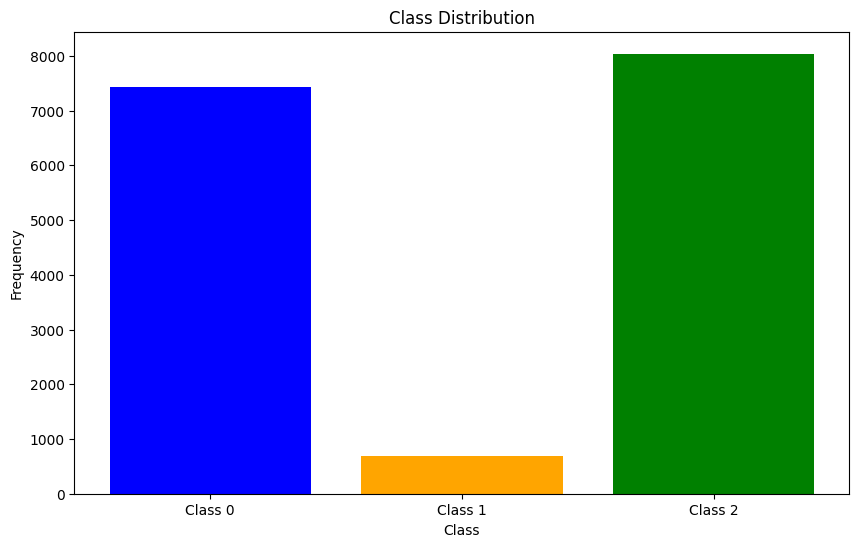

In [ ]:
# Visualizing class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color=['blue', 'orange', 'green'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(unique_classes, ['Class 0', 'Class 1', 'Class 2'])
plt.show()

In [ ]:
# Average classification report
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

all_precisions = []
all_recalls = []
all_f1s = []

for report in classification_reports:
    precision, recall, f1, _ = precision_recall_fscore_support(y_true=y_fold_val, y_pred=y_val_pred, average=None, zero_division=1)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)

average_precisions = np.mean(all_precisions, axis=0)
average_recalls = np.mean(all_recalls, axis=0)
average_f1s = np.mean(all_f1s, axis=0)

print("Average Precision per Class:", average_precisions)
print("Average Recall per Class:", average_recalls)
print("Average F1-Score per Class:", average_f1s)

Average Precision per Class: [0.75147059 1.         0.72998933]
Average Recall per Class: [0.68682796 0.         0.85180573]
Average F1-Score per Class: [0.71769663 0.         0.7862069 ]


Average Confusion Matrix:
 [[5.093e+02 5.000e-01 2.341e+02]
 [4.500e+01 1.300e+00 2.350e+01]
 [1.214e+02 4.000e-01 6.820e+02]]


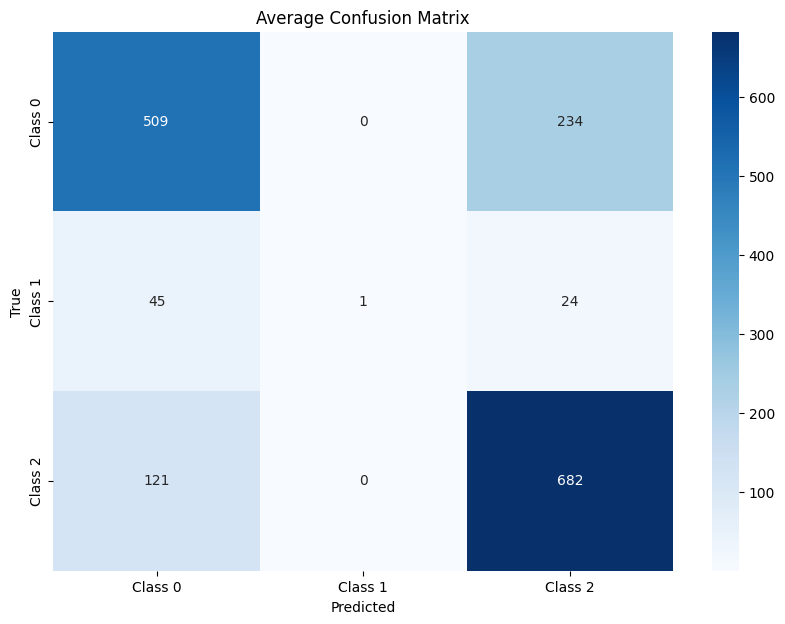

In [ ]:
# Error analysis
from sklearn.metrics import confusion_matrix

# Aggregate confusion matrices from each fold
conf_matrices = []
for train_index, val_index in skf.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    lr_model = LogisticRegression(max_iter=2000)
    lr_model.fit(X_fold_train, y_fold_train)
    y_val_pred = lr_model.predict(X_fold_val)
    conf_matrix = confusion_matrix(y_fold_val, y_val_pred)
    conf_matrices.append(conf_matrix)

# Average confusion matrix
average_conf_matrix = np.mean(conf_matrices, axis=0)

print("Average Confusion Matrix:\n", average_conf_matrix)

# Visualize confusion matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(average_conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Average Confusion Matrix')
plt.show()

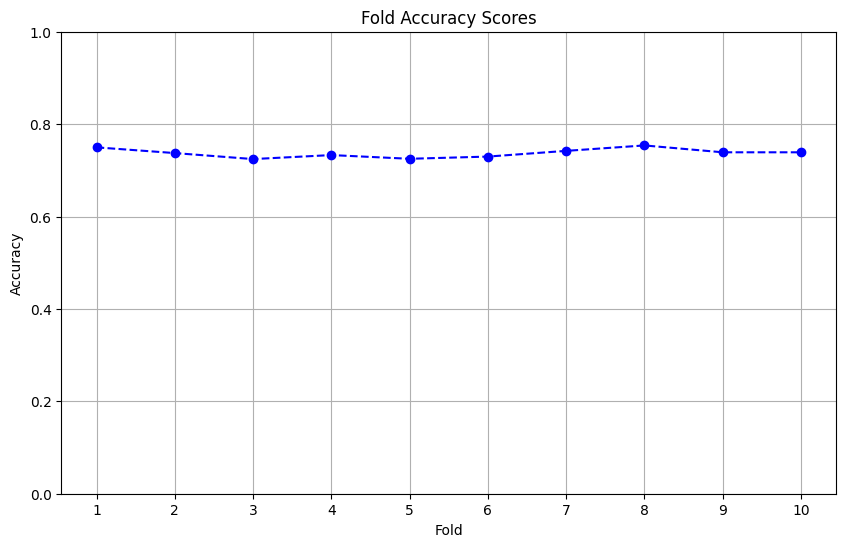

In [ ]:
# Visualize accuracy across folds
plt.figure(figsize=(10, 6))
plt.plot(range(1, k+1), accuracy_scores, marker='o', linestyle='--', color='b')
plt.title('Fold Accuracy Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, k+1))
plt.ylim(0, 1)
plt.grid(True)
plt.show()